In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from quick_pp.objects import Project

# Load well from saved file
project = "TS"
project_path = rf"data\04_project\{project}.qppp"
project = Project().load(project_path)
project.get_well_names()

['Gedombak-1',
 'Irama North-1 ST1',
 'Irama North-1',
 'MalikaiDeep-1S1',
 'Mirdanga-1 BOT',
 'Mirdanga-1 TOP',
 'Nafiri-1',
 'Nahara-1']

In [3]:
# Load data
well_name = 'MalikaiDeep-1S1'
well = project.get_well(well_name)
well_data = well.data.copy()
well_data.columns = [col.replace('LFP_', '') for col in well_data.columns]
replace_cols = {
    'NEU': 'NPHI',
    'DEN': 'RHOB',
    'NEUT_HC': 'NPHI_HC',
    'DEN_HC': 'RHOB_HC',
    'VSH': 'VSHALE'
}
well_data.rename(columns=replace_cols, inplace=True)
well_data.columns

Index(['UWI', 'WELL_NAME', 'DEPTH', 'BVW_JUH', 'COAL', 'RHOB', 'RHOB_HC', 'GR',
       'NPHI', 'NPHI_HC', 'PERM_ED', 'PHISAND_TS', 'POR_HC', 'RH', 'RH_SHALE',
       'RSAND', 'RT', 'RV', 'RV_SHALE', 'SWT_JUH', 'SWT_JUH_UNCL', 'SXO_HC',
       'VLAM_TS', 'VLAMT', 'VSHALE'],
      dtype='object')

# Quick PP Interpretation

In [4]:
from quick_pp.lithology.thin_beds import ThinBeds
from quick_pp.porosity import neu_den_xplot_poro, density_porosity, rho_matrix, normalize_volumetric, clay_porosity
from quick_pp.qaqc import badhole_flagging, mask_outside_threshold, neu_den_xplot_hc_correction, den_correction
from quick_pp.saturation import *
from quick_pp.permeability import *
from quick_pp.ressum import *
from quick_pp.rock_type import rock_typing, estimate_vsh_gr
from quick_pp.plotter.plotter import plotly_log, neutron_density_xplot
from quick_pp.utils import zone_flagging, min_max_line

## Estimate Litholoy

In [9]:
args = {
    'fluid_point': (1, 1),
    'dry_min1_point': (-.02, 2.65),
    'dry_clay_point': (.4, 2.75),
    'dry_sand_poro': 0.38,
    'dry_shale_poro': 0.18,
}
tb_model = ThinBeds(**args)

# filtered_df = well_data[(well_data.DEPTH > 3800) & (well_data.DEPTH < 3900)].copy()
filtered_df = well_data.copy()
filtered_df['DEPTH'] = filtered_df.DEPTH * 3.28084  # Convert to feet
vsand, vshale, phit, vsh_lam, vsh_dis, vsand_dis, phit_sand = tb_model.estimate_litho_poro(filtered_df.NPHI, filtered_df.RHOB)

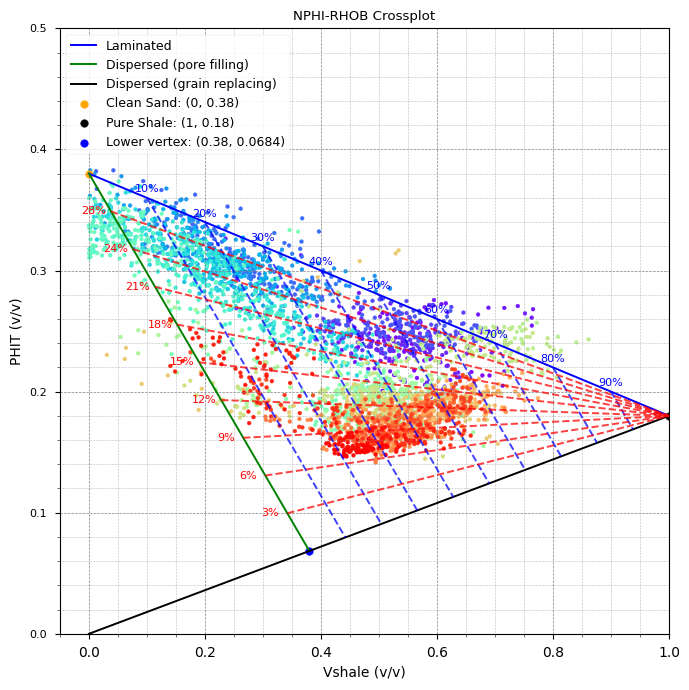

In [11]:
from quick_pp.lithology.thin_beds import vsh_phit_xplot

vsh_phit_xplot(vshale, phit, **args)

[2025-06-10 12:09:47] INFO     | quick_pp.plotter.plotter | Generating neutron-density crossplot.


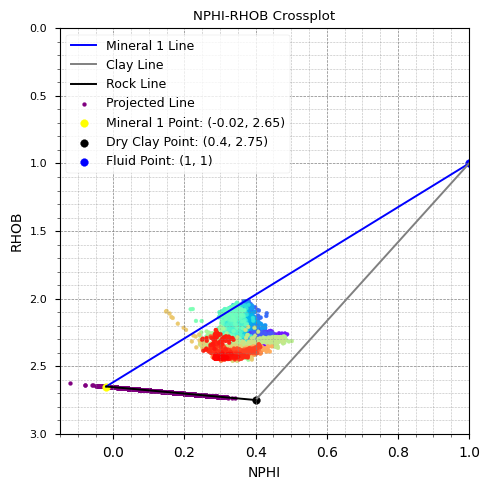

In [12]:
neutron_density_xplot(filtered_df['NPHI'], filtered_df['RHOB'], **args)

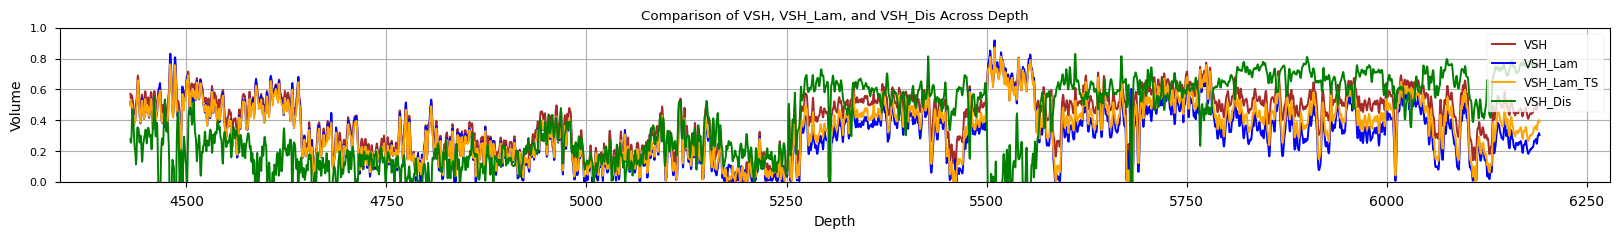

In [13]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(20, 2))
plt.plot(filtered_df.DEPTH.values, vshale, label='VSH', color='brown')
plt.plot(filtered_df.DEPTH.values, vsh_lam, label='VSH_Lam', color='blue')
plt.plot(filtered_df.DEPTH.values, filtered_df.VLAM_TS, label='VSH_Lam_TS', color='orange')
# plt.plot(filtered_df.DEPTH.values, filtered_df.VLAMT, label='VSH_Lam_T', color='red')
plt.plot(filtered_df.DEPTH.values, vsh_dis, label='VSH_Dis', color='green')

plt.xlabel('Depth')
plt.ylabel('Volume')
plt.ylim(0, 1)
plt.title('Comparison of VSH, VSH_Lam, and VSH_Dis Across Depth')
plt.legend()
plt.grid()
plt.show()

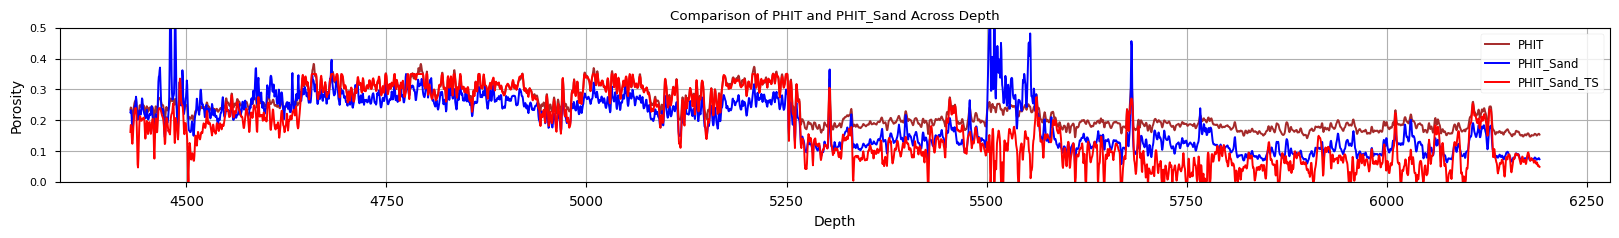

In [14]:
# Plotting
plt.figure(figsize=(20, 2))
plt.plot(filtered_df.DEPTH.values, phit, label='PHIT', color='brown')
plt.plot(filtered_df.DEPTH.values, phit_sand, label='PHIT_Sand', color='blue')
plt.plot(filtered_df.DEPTH.values, filtered_df.PHISAND_TS, label='PHIT_Sand_TS', color='red')

plt.xlabel('Depth')
plt.ylabel('Porosity')
plt.ylim(0, 0.5)
plt.title('Comparison of PHIT and PHIT_Sand Across Depth')
plt.legend()
plt.grid()
plt.show()

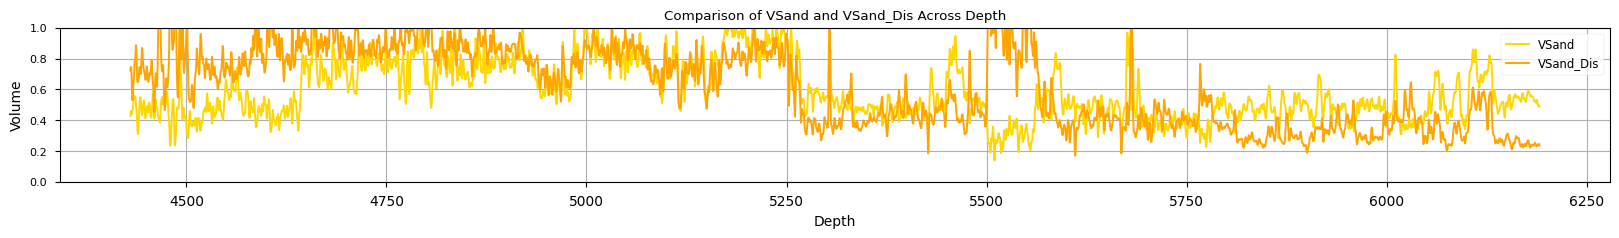

In [15]:
# Plotting
plt.figure(figsize=(20, 2))
plt.plot(filtered_df.DEPTH.values, vsand, label='VSand', color='gold')
plt.plot(filtered_df.DEPTH.values, vsand_dis, label='VSand_Dis', color='orange')

plt.xlabel('Depth')
plt.ylabel('Volume')
plt.ylim(0, 1)
plt.title('Comparison of VSand and VSand_Dis Across Depth')
plt.legend()
plt.grid()
plt.show()

In [16]:
args.update({
    'hc_corr_angle': 50,
    'hc_buffer': 0.01,
})
vsh_gr = estimate_vsh_gr(filtered_df['GR'], min_gr=0, max_gr=140)
nphihc, rhobhc, hc_flag = neu_den_xplot_hc_correction(
    filtered_df['NPHI'], filtered_df['RHOB'], vsh_gr=vsh_gr,
    dry_min1_point=args['dry_min1_point'],
    dry_clay_point=args['dry_clay_point'],
    corr_angle=args['hc_corr_angle'], buffer=args['hc_buffer']
)

# Correct density log
rhob_corr = den_correction(nphihc, filtered_df['GR'], vsh_gr=vsh_gr, alpha=0.1)

In [17]:
args = {
    'fluid_point': (1, 1),
    'dry_min1_point': (-.02, 2.65),
    'dry_clay_point': (.4, 2.75),
    'dry_sand_poro': 0.38,
    'dry_shale_poro': 0.18,
}
tb_model = ThinBeds(**args)

vsand, vshale, phit, vsh_lam, vsh_dis, vsand_dis, phit_sand = tb_model.estimate_litho_poro(nphihc, rhob_corr)

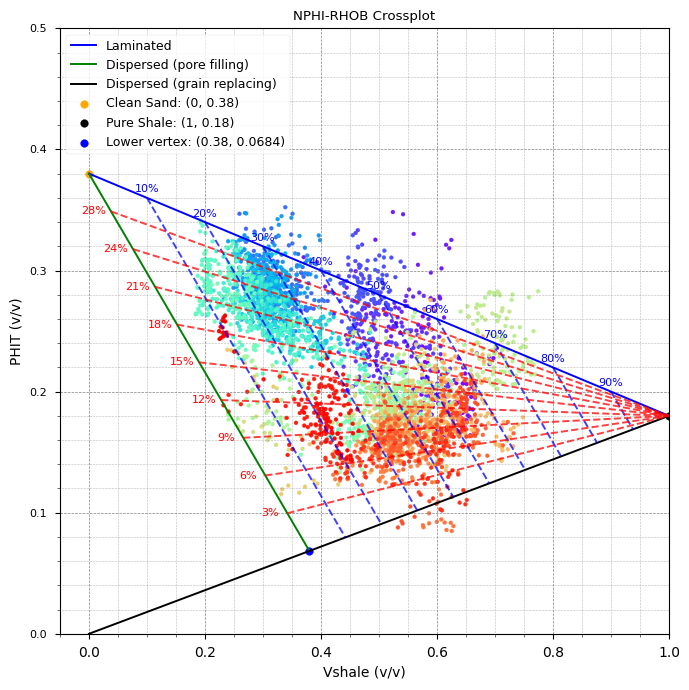

In [20]:
from quick_pp.lithology.thin_beds import vsh_phit_xplot

vsh_phit_xplot(vshale, phit, **args)

[2025-06-10 12:10:17] INFO     | quick_pp.plotter.plotter | Generating neutron-density crossplot.


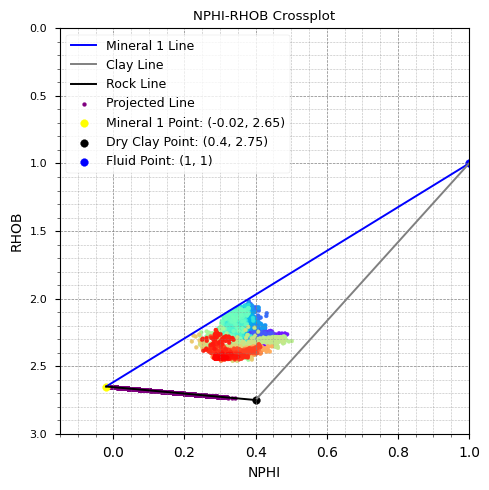

In [21]:
neutron_density_xplot(nphihc, rhobhc, **args)

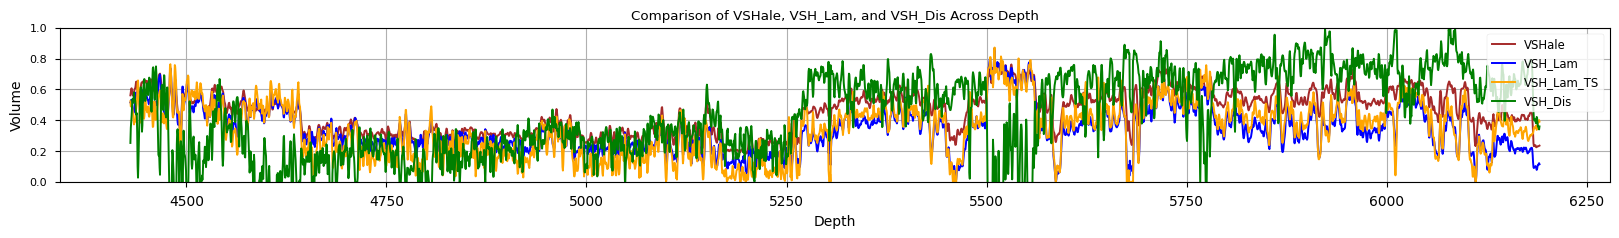

In [22]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(20, 2))
plt.plot(filtered_df.DEPTH.values, vshale, label='VSHale', color='brown')
plt.plot(filtered_df.DEPTH.values, vsh_lam, label='VSH_Lam', color='blue')
plt.plot(filtered_df.DEPTH.values, filtered_df.VLAM_TS, label='VSH_Lam_TS', color='orange')
plt.plot(filtered_df.DEPTH.values, vsh_dis, label='VSH_Dis', color='green')

plt.xlabel('Depth')
plt.ylabel('Volume')
plt.ylim(0, 1)
plt.title('Comparison of VSHale, VSH_Lam, and VSH_Dis Across Depth')
plt.legend()
plt.grid()
plt.show()

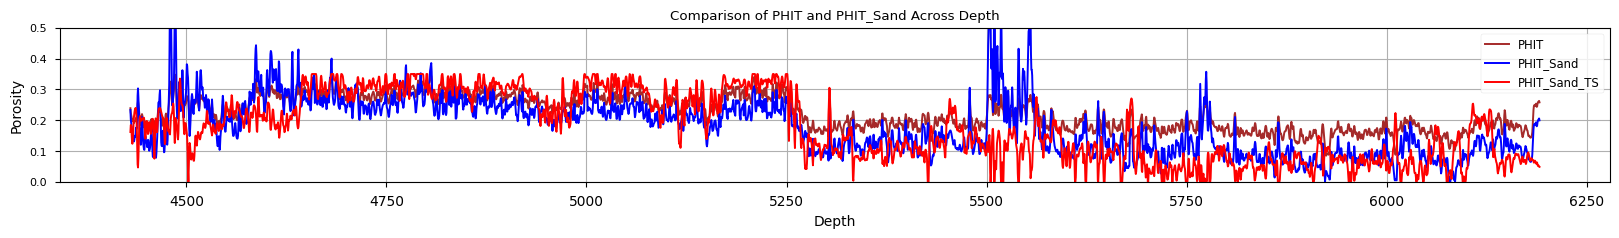

In [23]:
# Plotting
plt.figure(figsize=(20, 2))
plt.plot(filtered_df.DEPTH.values, phit, label='PHIT', color='brown')
plt.plot(filtered_df.DEPTH.values, phit_sand, label='PHIT_Sand', color='blue')
plt.plot(filtered_df.DEPTH.values, filtered_df.PHISAND_TS, label='PHIT_Sand_TS', color='red')

plt.xlabel('Depth')
plt.ylabel('Porosity')
plt.ylim(0, 0.5)
plt.title('Comparison of PHIT and PHIT_Sand Across Depth')
plt.legend()
plt.grid()
plt.show()

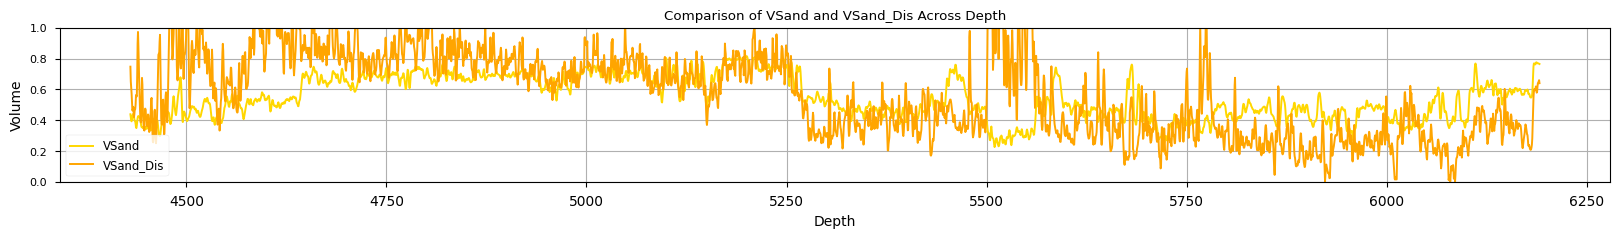

In [24]:
# Plotting
plt.figure(figsize=(20, 2))
plt.plot(filtered_df.DEPTH.values, vsand, label='VSand', color='gold')
plt.plot(filtered_df.DEPTH.values, vsand_dis, label='VSand_Dis', color='orange')

plt.xlabel('Depth')
plt.ylabel('Volume')
plt.ylim(0, 1)
plt.title('Comparison of VSand and VSand_Dis Across Depth')
plt.legend()
plt.grid()
plt.show()

## Resistivity Modelling

In [26]:
filtered_df.columns

Index(['UWI', 'WELL_NAME', 'DEPTH', 'BVW_JUH', 'COAL', 'RHOB', 'RHOB_HC', 'GR',
       'NPHI', 'NPHI_HC', 'PERM_ED', 'PHISAND_TS', 'POR_HC', 'RH', 'RH_SHALE',
       'RSAND', 'RT', 'RV', 'RV_SHALE', 'SWT_JUH', 'SWT_JUH_UNCL', 'SXO_HC',
       'VLAM_TS', 'VLAMT', 'VSHALE'],
      dtype='object')

(0.2, 200)

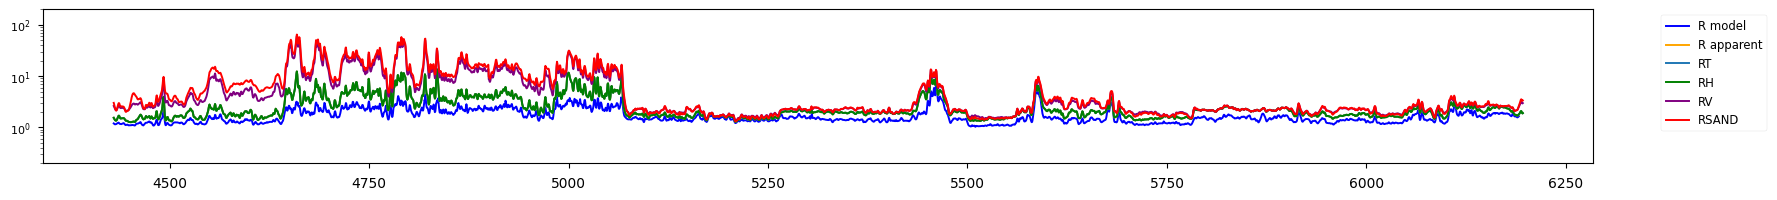

In [29]:
rapparent = tb_model.apparent_resistivity(rv=filtered_df.RV, rh=filtered_df.RH, theta=5)
rmodel = tb_model.resistivity_modelling(
    vsh_lam=vsh_lam,
    rsand=filtered_df.RT,
    rh_shale=1,
    rv_shale=2.2,
    theta=5
)

plt.figure(figsize=(20, 2))
plt.plot(filtered_df.DEPTH, rmodel, label='R model', color='blue')
plt.plot(filtered_df.DEPTH, rapparent, label='R apparent', color='orange')
plt.plot(filtered_df.DEPTH, filtered_df.RT, label='RT')
plt.plot(filtered_df.DEPTH, filtered_df.RH, label='RH', color='green')
plt.plot(filtered_df.DEPTH, filtered_df.RV, label='RV', color='purple')
plt.plot(filtered_df.DEPTH, filtered_df.RSAND, label='RSAND', color='red')


plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.yscale('log')
plt.ylim(0.2, 200)
